## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/cs445_projects/proj3/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

cp: /content/drive/My Drive/cs445_projects/proj3/utils.py: No such file or directory
cp: /content/drive/My Drive/cs445_projects/proj3/samples: No such file or directory


In [5]:
%matplotlib inline

## Part 1 Toy Problem (20 pts)

In [6]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    
    # TO DO
    im_h, im_w = img.shape 
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w) 


    neq = 1 + im_h * (im_w - 1) + im_w * (im_h - 1)
    A = scipy.sparse.lil_matrix((neq,  im_h * im_w), dtype='double') # init lil
    b = np.zeros((neq, 1), dtype='double')



    e = 0
    
    
    for x in range(im_h):
        for y in range(im_w-1):
            A[e, im2var[x][y+1]] = 1 
            A[e, im2var[x][y]] = -1 
            b[e] = img[x][y+1] - img[x][y]
            e += 1
    
    for x in range(im_h-1):
        for y in range(im_w):   
            A[e, im2var[x+1][y]] = 1
            A[e, im2var[x][y]] = -1 
            b[e] = img[x+1][y] - img[x][y]
            e += 1
            
    A[e, im2var[0][0]] = 1 
    b[e] = img[0][0]
            
    
   


    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=10**-10, btol=10**-10)
    
    return v[0].reshape((im_h, im_w))




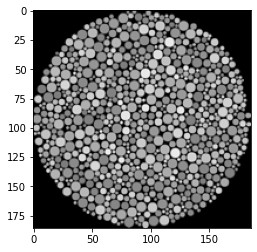

Max error is:  7.936000561381746e-08


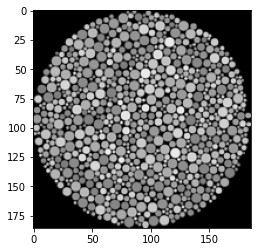

In [7]:
toy_img = cv2.cvtColor(cv2.imread('samples/colorBlind4.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.savefig("sss.jpg")
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

In [2]:
background_img = cv2.cvtColor(cv2.imread('wall.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
#plt.figure()
plt.imshow(background_img)
plt.show()
object_img_org = cv2.cvtColor(cv2.imread('ar.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

plt.imshow(object_img_org)
plt.show()

print(object_img_org.shape, background_img.shape)
use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  # xs = (65, 359, 359, 65)
  # # ys = (24, 24, 457, 457)
  xs = (10, 400, 400, 10)
  ys = (5, 5, 400, 400)
  object_mask = utils.get_mask(ys, xs, object_img_org)
  bottom_center = (500, 2500) # (x,y)
  bottom_center = (300, 400) # (x,y)
  # plt.imshow(object_mask)
  # plt.show()
  object_img, object_mask = utils.crop_object_img(object_img_org, object_mask)
  # plt.imshow(object_img)
  # plt.show()
  print(object_img.shape, object_mask.shape)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



NameError: name 'cv2' is not defined

In [ ]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib notebook
  mask_coords = specify_mask(object_img)

In [ ]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = get_mask(ys, xs, object_img)

In [ ]:
if use_interface:
  %matplotlib notebook
  import matplotlib.pyplot as plt
  bottom_center = specify_bottom_center(background_img)
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))



## Part 2 Poisson Blending (50 pts)

In [ ]:
def poisson_blend(object_img, object_org, bg_img, bg_ul, offset):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 

    off_x, off_y = offset

    im_h, im_w = object_img.shape 

    
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w) 

    # print(object_img.shape, object_mask.shape)
    # return
    neq = 4 * im_h * im_w + 1

    A = scipy.sparse.lil_matrix((neq,  im_h * im_w), dtype='double') # init lil
    b = np.zeros((neq, 1), dtype='double')

    e = 0
    
    for x in range(im_h):
        for y in range(im_w):
            for k in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
                if  0 <= k[0] < im_h and 0 <= k[1] < im_w:
                    A[e, im2var[x][y]] = 1 
                    A[e, im2var[k]] = -1 
                    b[e] = object_img[x][y] - object_img[k]
                else:
                    A[e, im2var[x][y]] = 1 
                    b[e] = object_img[x][y] - object_org[off_x+k[0], off_y+k[1]] + bg_img[bg_ul[0]+k[0], k[1]+bg_ul[1]]

                
                e += 1
        


    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=10**-10, btol=10**-10)

    plt.imshow(v[0].reshape((im_h, im_w)))
    
    bg_img[bg_ul[0]: bg_ul[0]+im_h, bg_ul[1]: im_w+bg_ul[1]] = v[0].reshape((im_h, im_w))


    return bg_img
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


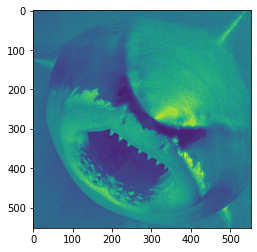

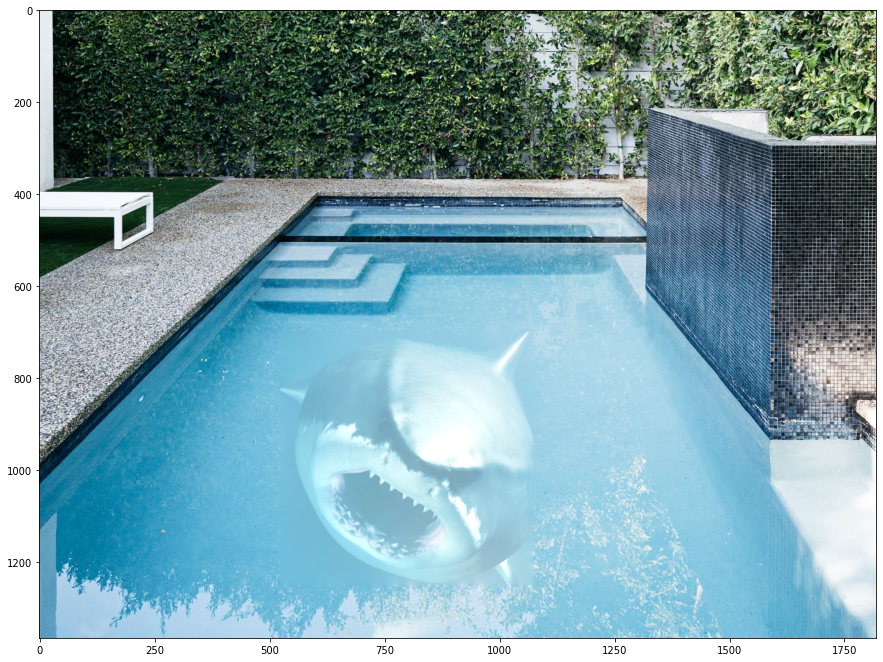

In [ ]:
im_blend = np.zeros(background_img.shape)
offset = (300,300)
for b in np.arange(3):
  im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_img_org[:,:,b], background_img[:,:,b].copy(), bg_ul, offset)

plt.figure(figsize=(15,15))
plt.imshow(im_blend)

## Part 3 Mixed Gradients (20 pts)

In [ ]:
def mixed_blend(object_img, object_org, bg_img, bg_ul, offset):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO 
    off_x, off_y = offset

    im_h, im_w = object_img.shape 

    
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w) 

    # print(object_img.shape, object_mask.shape)
    # return
    neq = 4 * im_h * im_w + 1

    A = scipy.sparse.lil_matrix((neq,  im_h * im_w), dtype='double') # init lil
    b = np.zeros((neq, 1), dtype='double')

    e = 0
    
    for x in range(im_h):
        for y in range(im_w):
            for k in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
                
                if  0 <= k[0] < im_h and 0 <= k[1] < im_w:
                    gra1 = object_img[x][y] - object_img[k]
                    gra2 = bg_img[bg_ul[0]+x][bg_ul[1]+y] - bg_img[bg_ul[0]+k[0]][bg_ul[1]+k[1]]
                    A[e, im2var[x][y]] = 1 
                    A[e, im2var[k]] = -1 
                    # print(gra1)
                    # print(gra2)
                    if abs(gra1) > abs(gra2):
                        b[e] = gra1
                    else:
                        b[e] = gra2
                else:
                    gra1 = object_img[x][y] - object_org[off_x+k[0], off_y+k[1]] 
                    gra2 = bg_img[bg_ul[0]+x][bg_ul[1]+y] - bg_img[bg_ul[0]+k[0]][bg_ul[1]+k[1]]
                    A[e, im2var[x][y]] = 1 
                    # print(gra1)
                    # print(gra2)
                    if abs(gra1) > abs(gra2):
                        b[e] = gra1 + bg_img[bg_ul[0]+k[0], k[1]+bg_ul[1]]
                    else:
                        b[e] = gra2 + bg_img[bg_ul[0]+k[0], k[1]+bg_ul[1]]


                
                e += 1
        


    v = scipy.sparse.linalg.lsqr(A.tocsr(), b, atol=10**-10, btol=10**-10)

    plt.imshow(v[0].reshape((im_h, im_w)))
    
    bg_img[bg_ul[0]: bg_ul[0]+im_h, bg_ul[1]: im_w+bg_ul[1]] = v[0].reshape((im_h, im_w))


    return bg_img
    



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


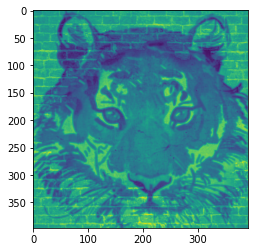

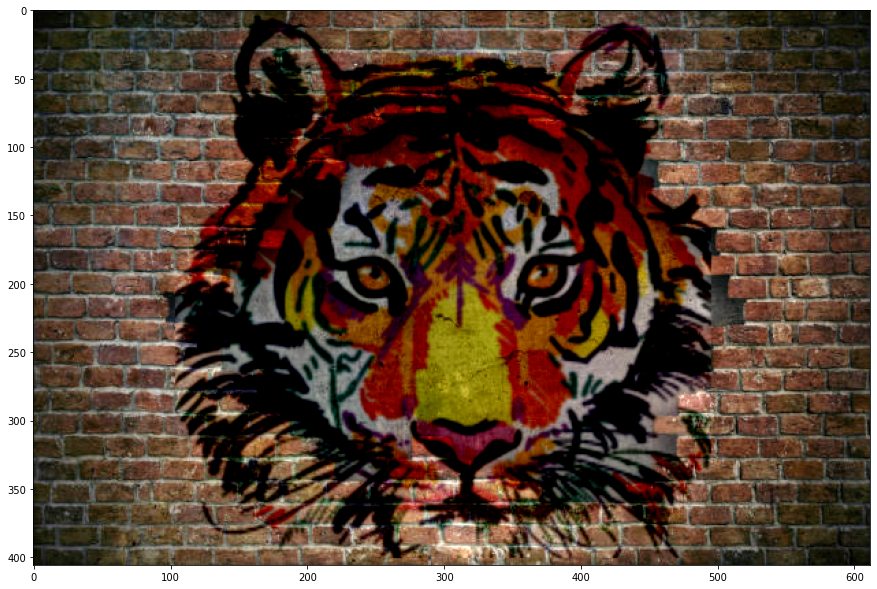

In [ ]:
im_mix = np.zeros(background_img.shape)
offset = (5, 10)
for b in np.arange(3):
  im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_img_org[:,:,b], background_img[:,:,b].copy(), bg_ul, offset)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)